In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import statsmodels.api as sm

## Loading the data

In [2]:
mask_use = pd.read_csv('../data/raw/mask-use-by-county.csv')
mask_mandates = pd.read_csv("../data/raw/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
us_confirm_cases = pd.read_csv('../data/raw/confirmed_cases/RAW_us_confirmed_cases.csv')

### Filter out Polk, Florida

Florida, Polk has UID 84012105, FIPS 12105

In [3]:
polk_mask_use = mask_use[mask_use['COUNTYFP'] == 12105]
polk_mask_mandates = mask_mandates[(mask_mandates['State_Tribe_Territory'] == 'FL') & (mask_mandates['County_Name'] == 'Polk County')]
polk_confirm_cases = us_confirm_cases[(us_confirm_cases['Province_State'] == 'Florida') & (us_confirm_cases['Admin2'] == 'Polk')]

### Pivot the tables

In [4]:
polk_confirm_cases = pd.DataFrame(polk_confirm_cases.iloc[:, 11:].iloc[0]).reset_index()
polk_confirm_cases.columns = ['Date', 'Confirmed_cases']

In [5]:
total_us_confirm_cases = us_confirm_cases.iloc[:, 11:].sum()
total_us_confirm_cases = pd.DataFrame(total_us_confirm_cases.reset_index())
total_us_confirm_cases.columns = ['Date', 'Confirmed_cases']

### Date Conversions

In [7]:
polk_mask_mandates['date'] = pd.to_datetime(polk_mask_mandates['date'])
polk_confirm_cases['Date'] = pd.to_datetime(polk_confirm_cases['Date'])
total_us_confirm_cases['Date'] = pd.to_datetime(total_us_confirm_cases['Date'])

/var/folders/t1/t_yjgylx77s8pm8k27dxwr9m0000gn/T/ipykernel_67614/1693823347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  polk_mask_mandates['date'] = pd.to_datetime(polk_mask_mandates['date'])


### Select Dates from Feb 1, 2020 to Oct 1, 2021

In [8]:
polk_confirm_cases = polk_confirm_cases[(polk_confirm_cases['Date'] > '2020-02-01') & (polk_confirm_cases['Date'] < '2021-10-01')]
total_us_confirm_cases = total_us_confirm_cases[(total_us_confirm_cases['Date'] > '2020-02-01') & (total_us_confirm_cases['Date'] < '2021-10-01')]

## Visualization

For your county, you should create a time series showing the changes in the derivative function of the rate of infection. Your graph should indicate days where masking policies were in effect (or not) and whether the difference in the derivative function was significant. <br>

First, we could visualize the confirmed cases and deaths and see the trend.

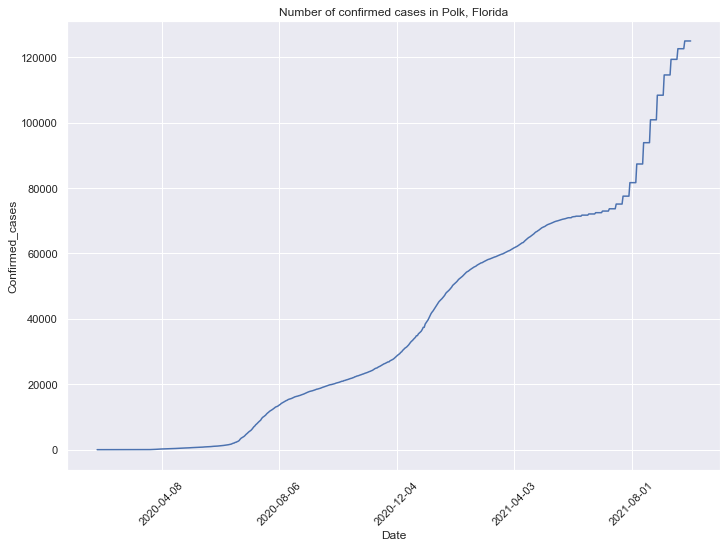

In [9]:
# Plotting Confirmed Cases
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x='Date', y='Confirmed_cases', data=polk_confirm_cases)
ax.xaxis.set_major_locator(locator=MultipleLocator(120))
xticks = plt.xticks(rotation=45)
title = plt.title('Number of confirmed cases in Polk, Florida')

### Visualizing the derivative function

We could use a sliding window for visualizing the derivative. For each date, we consider the value of 2 days before that date the value 2 days after that date to obtain the derivative of that date.

In [11]:
polk_confirm_cases['Rate_of_Change'] = polk_confirm_cases.shift(periods=-2)['Confirmed_cases'] - polk_confirm_cases.shift(periods=2)['Confirmed_cases']

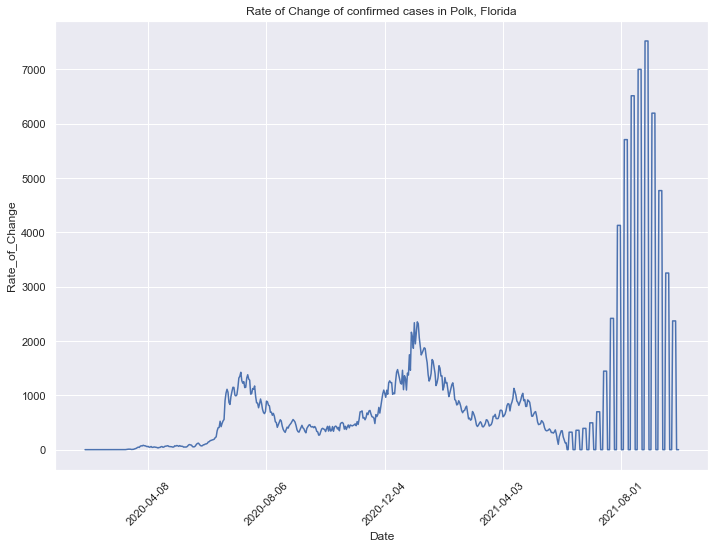

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x='Date', y='Rate_of_Change', data=polk_confirm_cases)
ax.xaxis.set_major_locator(locator=MultipleLocator(120))
xticks = plt.xticks(rotation=45)
title = plt.title('Rate of Change of confirmed cases in Polk, Florida')

### Relationship with mask policies

In [13]:
polk_mask_mandates.sum()

/var/folders/t1/t_yjgylx77s8pm8k27dxwr9m0000gn/T/ipykernel_67614/1076764515.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  polk_mask_mandates.sum()


State_Tribe_Territory            FLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFL...
County_Name                      Polk CountyPolk CountyPolk CountyPolk CountyPo...
FIPS_State                                                                    5916
FIPS_County                                                                  51765
order_code                                                                     986
Face_Masks_Required_in_Public                                                    0
Source_of_Action                                                                 0
URL                                                                              0
Citation                                                                         0
dtype: object

As we could see, there are no mask policies implemented in Polk from 2020-4-10 to 2021-8-15. This makes it a little tricky to model the impact of masking policies on the infection rates. Instead, we would have to model voluntary masking in this case. Since the data given is limited, we would have to look at how the past infection rates affect the future infection rates. Moreover, we could take a look at how the derivatives affect the future infection rates as well. Also, we could investigate the relationship of death rates and confirmed cases infection rate.

### Checking autocorrelation for Polk Infection Rate

Text(0.5, 1.0, 'Autocorrelation for Infection Rate of Change (Daily increase) in Polk')

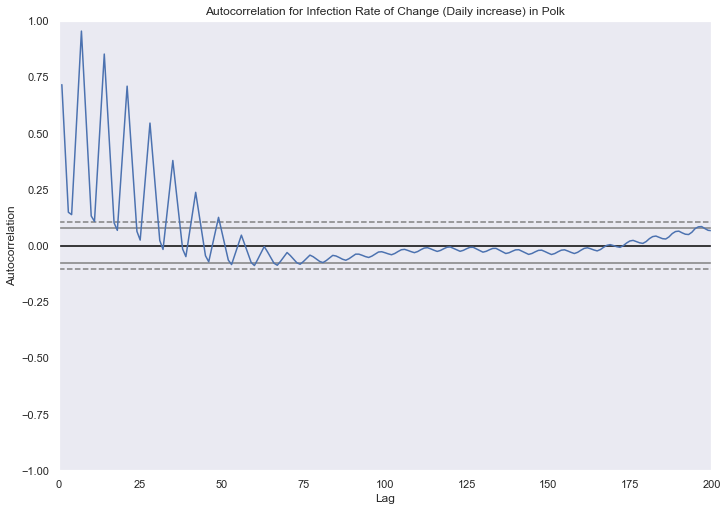

In [14]:
pd.plotting.autocorrelation_plot(polk_confirm_cases['Rate_of_Change'].dropna()).set_xlim([0, 200])
plt.title('Autocorrelation for Infection Rate of Change (Daily increase) in Polk')

In the meanwhile, we could create a cross correlation between the number of confirmed cases with some other variables, such as rate of change of confirmed cases, and confirmed cases of the entire US.

### Cross Correlation with US confirmed cases

In [15]:
# Calculating the rate of change
total_us_confirm_cases['Rate_of_Change'] = total_us_confirm_cases.shift(periods=-2)['Confirmed_cases'] - total_us_confirm_cases.shift(periods=2)['Confirmed_cases']

Text(0.5, 1.0, 'cross correlation between Polk daily increase and US daily increase')

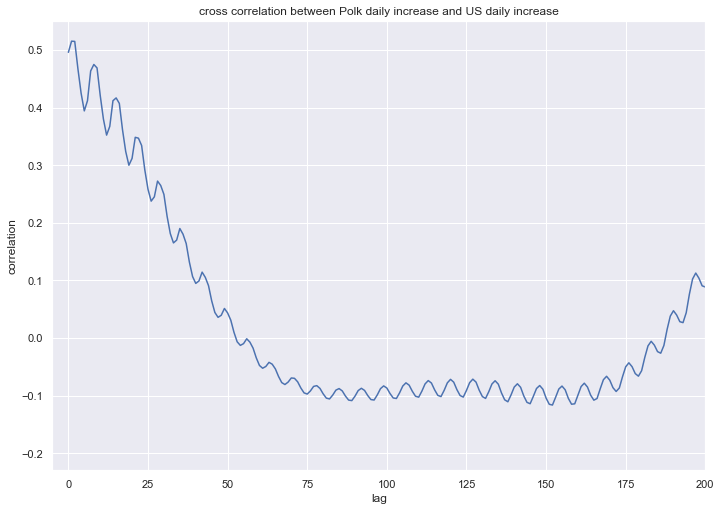

In [16]:
cross_corr_us_confirm = sm.tsa.ccf(polk_confirm_cases['Rate_of_Change'].dropna(), total_us_confirm_cases['Rate_of_Change'].dropna(), adjusted=False)
plt.plot(cross_corr_us_confirm)
plt.xlim(-5, 200)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.title('cross correlation between Polk daily increase and US daily increase')